In [1]:
import numpy as np
import pandas as pd
from os import listdir
from numpy import genfromtxt

## Get data

In [2]:
# Get time series data:
studyname = 'UCR'

In [3]:
def getdata(studyname,fileindex):
    if studyname == 'Utrecht':
        datadir = "/home/vincent/estep/data/utrecht"
        multivar = True #False # Are this Multivariate time series TRUE or FALSE
        multiclass = False
        Nfilesperelement = 4 #there are four files per patient
        labloc = "/home/vincent/estep/data/utrecht_labels.csv" # labels in column 1 (0), row 1 (1), or name of file
        idbloc = 2 # Id in column 1 (0), row 1 (1), seperate file (2), not applicable (3)
        timecol = False # time series per column (True) or per row (False)
    elif studyname == 'UCR':
        datadir = "/home/vincent/estep/data/UCR_TS_Archive_2015/50words"
        multivar = False # Are this Multivariate time series TRUE or FALSE
        multiclass = False
        Nfilesperelement = 0 #all elements are in one merged file
        labloc = 0 # Classifcation labels in column 1 (0), row 1 (1), seperate file (2)
        idbloc = 3 # Id in column 1 (0), row 1 (1), seperate file (2), not applicable (3)
        timecol = False # time series per column (True) or per row (False)
    else:
        raise ValueError(str(studyname) + ' is not a valid studyname')

    #============================================================================
    # Identify number of files and filetype based on datadir
    filenames = listdir(datadir)
    Nfiles = len(filenames) # number of files
    # Investigate what format the first file has by trying out a variety of reading attempts
    
    path = datadir + '/' + filenames[fileindex]
    delimiter = [None,','] #possible delimiter values
    skiprows=[0,1]
    ntests = len(delimiter)*len(skiprows)
    df = pd.DataFrame(index=range(ntests),columns=['delimiter','skiprows','nrow','ncol','first cell'])
    cnt = 0
    for di in delimiter:
        for si in skiprows:
            try:
                F1 = np.loadtxt(fname=path,delimiter=di,skiprows=si)
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = F1.shape[0]
                df['ncol'][cnt] = F1.shape[1]
                df['first cell'][cnt] = F1[0,1]
            except:
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = 0
                df['ncol'][cnt] = 0
                df['first cell'][cnt] = 0
            cnt = cnt + 1
    # df is now a dataframe with information to help identify how the data should be loaded
    # load one file based on the extracted information on fileformat
    form = df[df.nrow == max(df.nrow)] # extraction procedure that resulted in the largest number of rows is the best
    if form.shape[0] > 1:
        form = df[df.ncol == max(df.ncol)] # extraction procedure that resulted in the largest number of columns
    if (form['delimiter'] == ',').bool():
        F2 = np.loadtxt(fname=path,delimiter=',',skiprows=int(form['skiprows']))
    else:
        F2 = np.loadtxt(fname=path,delimiter=None,skiprows=int(form['skiprows']))
    # Extract labels y and data X, and standardize shape of matrix
    # Extract data based on newly gained insight into fileformat and data structure
    labtype = 'int'
    if labloc == 0:
        y = np.array(F2[:,0], dtype=labtype)
        X = F2[:,1:]
    elif labloc == 1:
        y = np.array(F2[0,:], dtype=labtype)
        X = F2[1:,:].transpose()
    filename = filenames[fileindex]

    return(X, y, filename, Nfiles)

In [4]:
# get data
Xtrain, ytrain, filenametrain, Nfiles = getdata('UCR',fileindex=0)
Xtest, ytest, filenametest, Nfiles = getdata('UCR',fileindex=1)

In [5]:
print(Xtrain.shape, ytrain.shape, filenametrain, Nfiles)
print(Xtest.shape, ytest.shape, filenametest, Nfiles)

(450, 270) (450,) 50words_TRAIN 2
(455, 270) (455,) 50words_TEST 2


# Design and compile some architectures

In [6]:
# Now, lets try to train some models
from keras.models import Sequential
from keras.layers import Merge, Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
import numpy as np
from keras.utils.np_utils import to_categorical

Using Theano backend.


In [7]:
timesteps = Xtrain.shape[1]
data_dim = 1
nb_classes = 51
X_train = Xtrain #np.random.random((100, timesteps))
y_train = ytrain #np.random.randint(nb_classes,size=(100,1))
X_test = Xtest #np.random.random((100, timesteps))
y_test = ytest #np.random.randint(nb_classes,size=(100,1))
y_train_original = y_train
y_test_original = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
idim = timesteps
model.add(Dense(64, input_dim=idim, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, init='uniform'))
model.add(Activation('softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [9]:
# reshape data, because LSTM requires different input format?
X_train2 = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test2 = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [10]:
# let's try out another model
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True,
               input_shape=(X_train2.shape[1], X_train2.shape[2])))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32))  # return a single vector of dimension 32
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Fit the architectures / models

In [11]:
#Fit model and store history of the fitting process
History = model.fit(X_train, y_train,
          nb_epoch=5,batch_size=20)

Epoch 1/5
450/450 [==============================] - 0s - loss: 3.7033 - acc: 0.1333     
Epoch 2/5
450/450 [==============================] - 0s - loss: 3.5243 - acc: 0.1889     
Epoch 3/5
450/450 [==============================] - 0s - loss: 3.7808 - acc: 0.1622     
Epoch 4/5
450/450 [==============================] - 0s - loss: 3.8459 - acc: 0.1200     
Epoch 5/5
450/450 [==============================] - 0s - loss: 3.7546 - acc: 0.1222     


In [12]:
#Fit model and store history of the fitting process
History2 = model2.fit(X_train2, y_train,batch_size=20,
                      nb_epoch=5,verbose=True,validation_split=0.2)

Train on 360 samples, validate on 90 samples
Epoch 1/5
360/360 [==============================] - 10s - loss: 3.7920 - acc: 0.0944 - val_loss: 3.6312 - val_acc: 0.1667
Epoch 2/5
360/360 [==============================] - 10s - loss: 3.6239 - acc: 0.1444 - val_loss: 3.5022 - val_acc: 0.2000
Epoch 3/5
360/360 [==============================] - 11s - loss: 3.5076 - acc: 0.1583 - val_loss: 3.3613 - val_acc: 0.2333
Epoch 4/5
360/360 [==============================] - 11s - loss: 3.3923 - acc: 0.1917 - val_loss: 3.2826 - val_acc: 0.2444
Epoch 5/5
360/360 [==============================] - 11s - loss: 3.2729 - acc: 0.2306 - val_loss: 3.2147 - val_acc: 0.2556


# Evaluate models on test set

In [13]:
score = model.evaluate(X_test, y_test, batch_size=20,verbose=False)
print('Model 1: ' + str(score))
score2 = model2.evaluate(X_test2, y_test, batch_size=20,verbose=False)
print('Model 2: ' + str(score2))

Model 1: [3.5592766070103909, 0.12527472845145635]
Model 2: [3.2424556056221765, 0.26813187098110114]


In [14]:
classes = model.predict_classes(X_test, batch_size=20)
proba = model.predict_proba(X_test, batch_size=20)

classes2 = model2.predict_classes(X_test2, batch_size=20)
proba2 = model2.predict_proba(X_test2, batch_size=20)

455/455 [==============================] - 4s     


In [15]:
proba2.shape

(455, 51)

In [16]:
classes2.shape

(455,)

In [17]:
classes2[0:10]

array([2, 7, 1, 3, 7, 1, 4, 1, 2, 1])

In [20]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_test_original)

array([[57, 42, 28, ...,  2,  4,  4],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [21]:
metrics.confusion_matrix(classes2, y_test_original)

array([[47,  3,  0, ...,  0,  0,  1],
       [10, 39,  1, ...,  0,  0,  3],
       [ 0,  0, 25, ...,  2,  3,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [23]:
print(np.hstack((proba2, np.vstack((classes, y_test_original)).transpose())))

[[  5.73778199e-03   7.25479871e-02   7.96562359e-02 ...,   9.08907596e-03
    1.00000000e+00   4.00000000e+00]
 [  7.53799779e-03   6.17215149e-02   7.17626140e-02 ...,   1.03835659e-02
    1.00000000e+00   1.20000000e+01]
 [  5.85873472e-03   1.85670674e-01   1.42671615e-01 ...,   5.63516328e-03
    1.00000000e+00   1.30000000e+01]
 ..., 
 [  7.88939465e-03   2.12618075e-02   3.32529545e-02 ...,   1.79702695e-02
    1.00000000e+00   2.50000000e+01]
 [  8.85977410e-03   1.03510030e-01   1.80674747e-01 ...,   7.58778770e-03
    1.00000000e+00   1.50000000e+01]
 [  1.15576899e-02   1.57506112e-02   2.19966713e-02 ...,   2.17222329e-02
    1.00000000e+00   1.60000000e+01]]


In [24]:
print(np.hstack((proba2, np.vstack((classes2, y_test_original)).transpose())))

[[  5.73778199e-03   7.25479871e-02   7.96562359e-02 ...,   9.08907596e-03
    2.00000000e+00   4.00000000e+00]
 [  7.53799779e-03   6.17215149e-02   7.17626140e-02 ...,   1.03835659e-02
    7.00000000e+00   1.20000000e+01]
 [  5.85873472e-03   1.85670674e-01   1.42671615e-01 ...,   5.63516328e-03
    1.00000000e+00   1.30000000e+01]
 ..., 
 [  7.88939465e-03   2.12618075e-02   3.32529545e-02 ...,   1.79702695e-02
    7.00000000e+00   2.50000000e+01]
 [  8.85977410e-03   1.03510030e-01   1.80674747e-01 ...,   7.58778770e-03
    2.00000000e+00   1.50000000e+01]
 [  1.15576899e-02   1.57506112e-02   2.19966713e-02 ...,   2.17222329e-02
    3.00000000e+00   1.60000000e+01]]


# Plot training process

In [25]:
#set up conditions for plotting
import matplotlib.pyplot as plt
%matplotlib inline

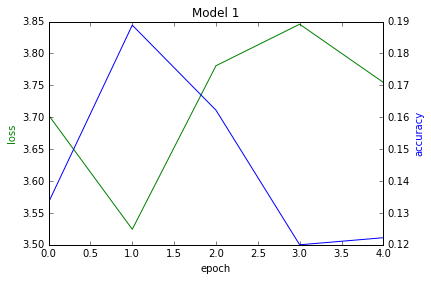

In [26]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History.history['loss'])
ax1.plot(range(LN),History.history['loss'],'g-')
ax2.plot(range(LN),History.history['acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 1')

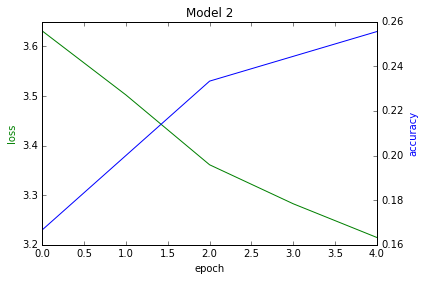

In [28]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History2.history['val_loss'])
ax1.plot(range(LN),History2.history['val_loss'],'g-')
ax2.plot(range(LN),History2.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 2')